<a href="https://colab.research.google.com/github/maudl3116/higherOrderKME/blob/main/examples/hypothesis_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Hypothesis testing on filtrations**
Reproduces the results for Example in Sec. 4.1 in [Higher Order Kernel Mean Embeddings to Capture Filtrations of Stochastic Processes](https://arxiv.org/pdf/2109.03582.pdf)
***

### First we install and import packages

In [ ]:
# Install the higherOrderKME library
!pip install git+https://github.com/maudl3116/higherOrderKME.git

In [ ]:
# Optional installation for Latex figures
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!pip install latex
!sudo apt install cm-super

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import higherOrderKME
from higherOrderKME import sigkernel

# Using seaborn's style
plt.style.use('seaborn-colorblind')
width = 345
tex_fonts = {
    "text.usetex": True,  # put False if this raises errors
    "font.family": "serif",
    "axes.labelsize": 24,
    "font.size": 22,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'figure.figsize': (7, 5),
}
plt.rcParams.update(tex_fonts)

In [2]:
device = 'cuda'

# 1) Visualize histograms for fixed hyperparameters

In [27]:
# number of path coordinates and number of time steps
D, L = 1, 3 

# experimental setup
repeats, n_samples, n, lambda_ = 100, 500, 5*1e5, 1e-5

MMD_1 = np.zeros((repeats, 2))
MMD_2 = np.zeros((repeats, 2))

# to store the sample paths from X_n and X
X = np.zeros((repeats, n_samples, 2, L, D)) 
X_n = np.zeros((repeats, n_samples, 2, L, D))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
omega_2 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X_n[:, :, :, 1, 0] = omega_1 * 1./n
X_n[:, :, :, 2, 0] = 0.1 * omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X[:, :, :, 2, 0] = 0.1 * omega_1

In [28]:
# setup the signature kernel

dyadic_order = 2
dyadic_order_1 = 1  

_naive_solver = False

static_kernel_1 = sigkernel.RBFKernel(sigma=1e-5, add_time=L-1)
static_kernel_21 = sigkernel.RBFKernel(sigma=1e-5, add_time=L-1)
static_kernel_22 = sigkernel.RBFKernel(sigma=2., add_time=L-1)

kernel_order1 = sigkernel.SigKernel(static_kernel_1, dyadic_order, _naive_solver)
kernel_order2 = sigkernel.SigKernel([static_kernel_21, static_kernel_22], [dyadic_order, dyadic_order_1], _naive_solver)

**Run the experiment**

In [29]:
for i in range(repeats):

    x0 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)     # X of shape (repeats,n_samples,2,L,D)
    x0_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    # independent copy of X
    xn = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
    xn_ = torch.tensor(X_n[i, :, 1, :, :], dtype=torch.float64).to(device)  # independent copy of X_n

    MMD_2[i,0] = kernel_order2.compute_mmd(x0, x0_, lambda_=lambda_, estimator='ub', order=2)   
    MMD_2[i,1] = kernel_order2.compute_mmd(xn, x0, lambda_=lambda_, estimator='ub', order=2)   
    
    MMD_1[i,0] = kernel_order1.compute_mmd(x0, x0_, estimator='ub', order=1)   
    MMD_1[i,1] = kernel_order1.compute_mmd(xn, x0, estimator='ub', order=1)   

**Generate the figure**

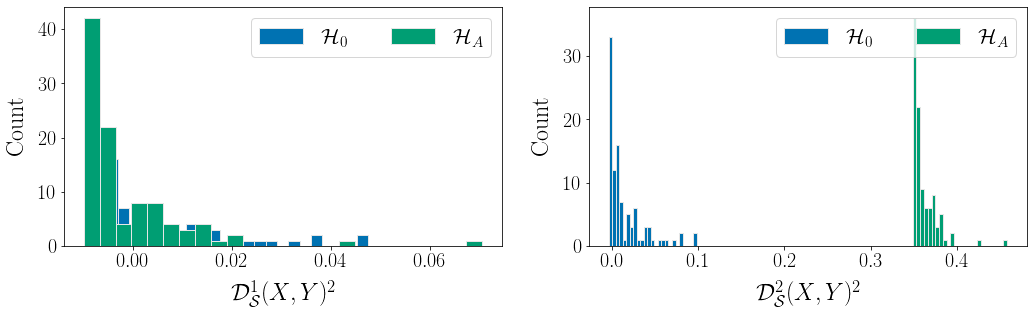

In [30]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(MMD_1[:,0], bins=25, label=r'$\mathcal{H}_0$',edgecolor='#E6E6E6')
ax[0].hist(MMD_1[:,1], bins=25, label=r'$\mathcal{H}_A$',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right', ncol=2, fontsize=22)
ax[0].set_xlabel(r'$\mathcal{D}^1_{\mathcal{S}}(X,Y)^2$', labelpad=10)
ax[0].set_ylabel('Count', labelpad=10)

ax[1].hist(MMD_2[:,0], bins=25, label=r'$\mathcal{H}_0$', edgecolor='#E6E6E6')
ax[1].hist(MMD_2[:,1], bins=25, label=r'$\mathcal{H}_A$', edgecolor='#E6E6E6')

ax[1].legend(loc='upper right', ncol=2, fontsize=22)
ax[1].set_xlabel(r'$\mathcal{D}^2_{\mathcal{S}}(X,Y)^2$', labelpad=10)
ax[1].set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

#2) Full two-sample test with 1st and 2nd order MMDs

We start by defining some utilities

### Second order kernel matrix

In [3]:
def K_order2(X, Y, kernel, return_order1=False):
    """
    Forms the kernel matrix K for the two sample test using the order2 or order1 kernel

    Parameters:
    X - (n_samples,n_obs,d) array of samples from the first distribution 
    Y - (n_samples,n_obs,d) array of samples from the second distribution 
    kernel - signature kernel
    
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """

    # Compute Gram matrices order 1. Ex K_XY_1[i,j,p,q]= k( X[i,:,:p], Y[j,:, :q])
    K_XX_1 = kernel.compute_Gram(X, X, sym=True, return_sol_grid=True)   # shape (batch_X, batch_X, length_X, length_X)
    K_YY_1 = kernel.compute_Gram(Y, Y, sym=True, return_sol_grid=True)   # shape (batch_Y, batch_Y, length_Y, length_Y)
    K_XY_1 = kernel.compute_Gram(X, Y, sym=False, return_sol_grid=True)  # shape (batch_X, batch_Y, length_X, length_Y)

    if return_order1:
      top = torch.cat([K_XX_1, K_XY_1], axis=1)
      bottom = torch.cat([K_XY_1.transpose(0,1), K_YY_1], axis=1)
      K = torch.cat([top, bottom], axis=0)
      return K

    # Compute Gram matrices order 2. Ex K_XY_2[i,j]= k( X^1[i], Y^1[j] ) where X^1[i] = t -> E[k(X,.) | F_t](omega_i)
    K_XX_2 = kernel.compute_HigherOrder_Gram(K_XX_1, K_XX_1, K_XX_1, kernel.lambda_, sym=True)       # shape (batch_X, batch_X)
    K_YY_2 = kernel.compute_HigherOrder_Gram(K_YY_1, K_YY_1, K_YY_1, kernel.lambda_, sym=True)       # shape (batch_Y, batch_Y)
    K_XY_2 = kernel.compute_HigherOrder_Gram(K_XX_1, K_XY_1, K_YY_1, kernel.lambda_, sym=False)      # shape (batch_X, batch_Y)

    top = torch.cat([K_XX_2, K_XY_2], axis=1)
    bottom = torch.cat([K_XY_2.transpose(0,1), K_YY_2], axis=1)
    K = torch.cat([top, bottom], axis=0)

    return K

###First order kernel matrix

In [4]:
def K_order1(X, Y, kernel):
    """
    Forms the kernel matrix K for the two sample test
    
    Parameters:
    X - (n_samples,n_obs,d) array of samples from the first distribution 
    Y - (n_samples,n_obs,d) array of samples from the second distribution 
    kernel - signature kernel
    
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """

    K_XX = kernel.compute_Gram(X, X, sym=True)
    K_YY = kernel.compute_Gram(Y, Y, sym=True)
    K_XY = kernel.compute_Gram(X, Y, sym=False)
    
    top = torch.cat([K_XX, K_XY], axis=1)
    bottom = torch.cat([K_XY.transpose(0,1), K_YY], axis=1)
    K = torch.cat([top,bottom], axis=0)

    return K

###Utility function to form the second order kernel matrix from the first order kernel matrix

In [5]:
def order2_from_order1(K_1, kernel, M):
  """
  Forms the kernel matrix K for the 2nd order two sample test using the precomputed 1st order kernel
  """
  K_XX_1 = K_1[:M, :M]
  K_YY_1 = K_1[M:, M:]
  K_XY_1 = K_1[:M, M:]

  # Compute Gram matrices order 2. Ex K_XY_2[i,j]= k( X^1[i], Y^1[j] ) where X^1[i] = t -> E[k(X,.) | F_t](omega_i)
  K_XX_2 = kernel.compute_HigherOrder_Gram(K_XX_1, K_XX_1, K_XX_1, kernel.lambda_, sym=True)       # shape (batch_X, batch_X)
  K_YY_2 = kernel.compute_HigherOrder_Gram(K_YY_1, K_YY_1, K_YY_1, kernel.lambda_, sym=True)       # shape (batch_Y, batch_Y)
  K_XY_2 = kernel.compute_HigherOrder_Gram(K_XX_1, K_XY_1, K_YY_1, kernel.lambda_, sym=False)      # shape (batch_X, batch_Y)
  
  top = torch.cat([K_XX_2, K_XY_2], axis=1)
  bottom = torch.cat([K_XY_2.transpose(0,1), K_YY_2], axis=1)
  K = torch.cat([top,bottom], axis=0)

  return K

In [6]:
def MMD_K(K, M,N, compute_var=False):
    """
    Calculates the empirical MMD^{2} given a kernel matrix computed from the samples and the sample sizes of each distribution.
    
    Parameters:
    K - kernel matrix of all pairwise kernel values of the two distributions
    M - number of samples from first distribution
    N - number of samples from first distribution
    
    Returns:
    MMDsquared - empirical estimate of MMD^{2}
    """

    Kxx = K[:N, :N]
    Kyy = K[N:, N:]
    Kxy = K[:N, N:]

    t1 = (1./(M*(M-1)))*torch.sum(Kxx - torch.diag(torch.diagonal(Kxx)))
    t2 = (1./(M*(M-1)))*torch.sum(Kxy - torch.diag(torch.diagonal(Kxy)))
    t3 = (1./(N*(N-1)))* torch.sum(Kyy - torch.diag(torch.diagonal(Kyy)))
    
    MMDsquared = (t1 - 2.*t2 + t3)
    
    if not compute_var:
      return MMDsquared
    else:
      hh = Kxx + Kyy - Kxy - Kxy.transpose(0,1)
      V1 = torch.dot(hh.sum(1)/N,hh.sum(1)/N) / N
      V2 = (hh).sum() / (M) / M
      varEst = 4*(V1 - V2**2)
      if  varEst == 0.0:
        print('error!!' + str(V1))
      return MMDsquared, varEst

###Two-sample test with rank-1 and rank-2 MMD

In [7]:
def two_sample_test(X, Y, kernel, n_perms, z_alpha = 0.05, make_K = K_order1, return_perm=False, return_mmd=False):
  """
    Performs the two sample test and returns an accept or reject statement
    
    Parameters:
    X - (n_samples, n_obs, d) array of samples from the first distribution 
    Y - (n_samples, n_obs, d) array of samples from the second distribution 
    kernel - signature kernel
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    return_p - option to return the p-value of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    
    Returns:
    rej - 1 if null rejected, 0 if null accepted
    p-value - p_value of test
    
  """ 
  if make_K == K_order1:
    return two_sample_test1(X, Y, kernel, n_perms, z_alpha, make_K, return_perm, return_mmd)
  else:
    # Number of samples of each distribution is identified and kernel matrix formed
    M = X.shape[0]
    N = Y.shape[0]
    K_1 = make_K(X, Y, kernel, return_order1=True) # (batch_X, batch_X, length_X, length_X)

    # Empirical rank-2 MMD^{2} calculated
    K = order2_from_order1(K_1, kernel,M)
    MMD_test = MMD_K(K,M,N)

    if return_mmd:
      return MMD_test
    # For n_perms repeats the kernel matrix is shuffled and empirical MMD^{2} recomputed
    # to simulate the null
    shuffled_tests = np.zeros(n_perms)
    count=0

    for i in range(n_perms):
      idx = np.random.permutation(M + N)
      K_1_ = K_1[idx, idx[:, None]]
      K = order2_from_order1(K_1_, kernel, M)
      shuffled_tests[i] = MMD_K(K, M, N)

    # Threshold of the null calculated and test is rejected if empirical MMD^{2} of the data
    # is larger than the threshold
    q = np.quantile(shuffled_tests, 1.0 - z_alpha)
    rej = int(MMD_test > q)

    if return_perm:
      return rej, shuffled_tests
    return rej, None

In [8]:
def two_sample_test1(X, Y, kernel, n_perms, z_alpha = 0.05, make_K = K_order1, return_perm=False, return_mmd=False):
    """ wrapper for two_sample_test. We need a different perumation strategy for the second order MMD """
    
    # Number of samples of each distribution is identified and kernel matrix formed
    M = X.shape[0]
    N = Y.shape[0]
    K = make_K(X, Y, kernel)


    # Empirical MMD^{2} calculated
    MMD_test = MMD_K(K, M, N)
    
    if return_mmd:
      return MMD_test
    # For n_perms repeats the kernel matrix is shuffled and empirical MMD^{2} recomputed
    # to simulate the null
    shuffled_tests = np.zeros(n_perms)
    count=0
    for i in range(n_perms):
      idx = np.random.permutation(M + N)
      K_ = K[idx, idx[:, None]]
      shuffled_tests[i] = MMD_K(K_, M, N)

    # Threshold of the null calculated and test is rejected if empirical MMD^{2} of the data
    # is larger than the threshold
    q = np.quantile(shuffled_tests, 1.0 - z_alpha)
    rej = int(MMD_test > q)

    if return_perm:
      return rej, shuffled_tests

    return rej, None


###Computes the power of the tests

In [9]:
def power_test(X_samples, Y_samples, kernel, n_tests, n_perms, z_alpha = 0.05, make_K = K_order1, return_p = False, return_perm=False):
    """
    Computes multiple two-sample tests and returns the rejection rate
    
    Parameters:
    X_samples - (n_samples*n_tests,n_obs,d) array of samples from the first distribution 
    Y_samples - (n_samples*n_tests,n_obs,d) array of samples from the second distribution 
    kernel - bandwidth for the kernel
    n_tests - number of tests to perform
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    return_p - option to return the p-value of the test
    
    Returns:
    power - the rate of rejection of the null
    """
    
    # Number of samples of each distribution is identified
    M = int(X_samples.shape[0]/n_tests)
    N = int(Y_samples.shape[0]/n_tests)
    rej = np.zeros(n_tests)
    perms = np.zeros((n_tests, n_perms))
    # For each test, extract the data to use and then perform the two-sample test
    for t in tqdm(range(n_tests)):
        X_t = X_samples[t*M:(t+1)*M, :]
        Y_t = Y_samples[t*N:(t+1)*N, :]
  
        rej[t], shuffled_tests = two_sample_test(X_t, Y_t, kernel, n_perms, z_alpha = z_alpha, make_K = make_K, return_perm=return_perm)
        if perms is not None:
          perms[t]=shuffled_tests
    
    # Compute average rate of rejection
    power = np.mean(rej)
    
    if not return_perm:
      return power
    else:
      return power, perms

In [10]:
def hyper(X,Y, hyperparams=None, make_K=K_order1):
    
    # Number of samples of each distribution is identified
    M = int(X.shape[0])
    N = int(Y.shape[0])
   
    max = -100.
    best = None
    for i, param in enumerate(hyperparams):
      
      # create kernel
      static_kernel = [sigkernel.RBFKernel(sigma=param[0],add_time=L-1), sigkernel.RBFKernel(sigma=param[1],add_time=L-1)]
      signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order, _naive_solver)
      signature_kernel.lambda_ = param[2]

      # compute objective
      K = make_K(X, Y, signature_kernel)

      # Empirical MMD^{2} calculated
      res = MMD_K(K, M, N, compute_var=True)
      mmd_value_temp = (res[0] + 10 ** (-8))
      mmd_std_temp = torch.sqrt(res[1] + 10 ** (-8))
      
      if mmd_std_temp == 0:
          print('error!!')
      if torch.isnan(mmd_std_temp):
          print('error!!')
      obj = mmd_value_temp / mmd_std_temp
      if obj > max:
        best = param
        max = obj

    return best

###Generates data

In [11]:
def simul_null(repeats, n_samples,n, L=3, D=1):
  X = np.zeros((repeats*n_samples, L, D)) 
  omega_1 = np.random.choice(a=[-1, 1], size=repeats*n_samples)
  X[:, 2, 0] = 0.1*omega_1
  return X

def simul_alternative(repeats, n_samples,n, L=3, D=1):
  X_n = np.zeros((repeats*n_samples, L, D))
  omega_1 = np.random.choice(a=[-1, 1], size=repeats*n_samples)
  omega_2 = np.random.choice(a=[-1, 1], size=repeats*n_samples)
  X_n[:, 1, 0] = omega_1*1./n
  X_n[:, 2, 0] = 0.1*omega_1
  return X_n

###Experiment

In [16]:
# Parameters for the two sample test
n_tests = 100
n_perms = 100
M = 100  
N = M
L = 3
n_arr = [1e5, 2*1e5, 3*1e5, 5*1e5]  

In [17]:
# Set fixed hyperparameters for the signature kernel
dyadic_order = [2,1]
_naive_solver=False

In [ ]:
# To store the results for the MMD-1 and the MMD-2
powers_1 = np.zeros(len(n_arr))
powers_2 = np.zeros(len(n_arr))

power = True 

# performs two sample test for different values of n
for i in tqdm(range(len(n_arr))):
    n = n_arr[i]  
    print('Experiment with n={}'.format(n))

    """Chose hyperparameters"""

    # Generate an empirical distributions under the null
    X = simul_null(1, M, n, L=3, D=1)
    X = torch.tensor(X, dtype=torch.float64).cuda()
    
    if power:
      # Generate an empirical distributions under the alternative
      Y = simul_alternative(1, M, n, L=3, D=1)
    else:
      Y = simul_null(1, M, n, L=3, D=1)

    Y = torch.tensor(Y, dtype=torch.float64).cuda()

    # For the grid search over kernel hyperparameters
    p1 = list(itertools.product([1e-9,1e-8,1e-7,0.5*1e-6,1e-6,0.5*1e-5,1e-5,0.5*1e-4,1e-4,0.5*1e-3,1e-3,1e-2,1e-1,1,1e1,1e2],[1.],[1.]))
    p2 = list(itertools.product([1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2],[0.01,0.1,1,2,10],[1e-2,1e-3,1e-4,1e-5]))

    param1 = hyper(X, Y, p1, make_K = K_order1)
    sigma1 = param1[0]
    print('Optimal hyperparameters for MMD-1 sigma={}'.format(sigma1))
   
    # sigma1 = 1
    sigma1_ , sigma2_, lambda_ = hyper(X, Y, p2, make_K = K_order2)
    print('Optimal hyperparameters for MMD-2 sigma1={}, sigma2={}, lambda={}'.format(sigma1_, sigma2_, lambda_))
    # sigma1_ , sigma2_, lambda_ = 1e-5,2,1e-3

    """Set hyperparameters"""

    # For MMD-1
    static_kernel = sigkernel.RBFKernel(sigma=sigma1, add_time=L-1)
    kernel_1 = sigkernel.SigKernel(static_kernel, dyadic_order, _naive_solver)

    # For MMD-2
    static_kernel = [sigkernel.RBFKernel(sigma=sigma1_, add_time=L-1), sigkernel.RBFKernel(sigma=sigma2_, add_time=L-1)]
    kernel_2 = sigkernel.SigKernel(static_kernel, dyadic_order, _naive_solver)
    kernel_2.lambda_ = lambda_
    
    """Perform the test"""
    # generate n_tests empirical distributions under the null
    X = simul_null(n_tests, M, n, L=3, D=1)
    X = torch.tensor(X, dtype=torch.float64).cuda()

    
    if power:
      # generate n_tests empirical distributions under the alternative
      Y = simul_alternative(n_tests, M, n, L=3, D=1)
    else:
      Y = simul_null(n_tests, M, n, L=3, D=1)

    Y = torch.tensor(Y, dtype=torch.float64).cuda()

    powers_1[i] = power_test(X, Y, kernel_1, n_tests, n_perms, make_K = K_order1)
    powers_2[i] = power_test(X, Y, kernel_2, n_tests, n_perms, make_K = K_order2)
 

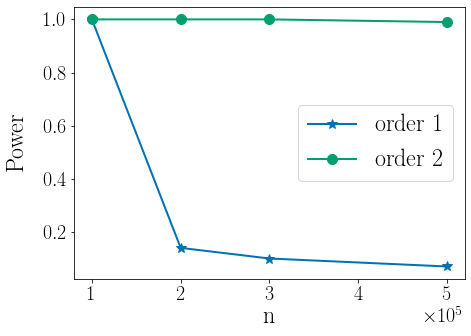

In [18]:
plt.plot(n_arr, powers_1, label='order 1', marker='*', markersize=10, linewidth=2)
plt.plot(n_arr, powers_2, label='order 2', marker='o', markersize=10, linewidth=2)
plt.xlabel('n')
plt.ylabel('Power', labelpad=15)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
# plt.savefig('Power_tex.pdf',bbox_inches='tight')
plt.show()